<a href="https://colab.research.google.com/github/khushbooG9/Pointer-Networks-Using-Fast-Weights/blob/master/boundary_PtrLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from __future__ import print_function
import random
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.enable_eager_execution()

In [0]:
class PtrNetLSTM(tf.keras.Model):
  def __init__(self, maxlen, batchsize, numblendunits, hiddensize=512): #J- input length, B-batch size, H-hidden units for lstm, D-blend units respectively
    super(PtrNetLSTM, self).__init__()
    self.maxlen = maxlen
    self.batchsize = batchsize
    self.hiddensize = hiddensize
    self.blendunits = numblendunits
    self.targetsize = 2 # (start,end) size 2 I
    self.input_dim = 1 # ignored, S-size of each vector
    self.generationsym = 20.0 #Used as starting value
    self.init = tf.random_normal_initializer(0.0, 0.5)
    self.encoder = tf.contrib.rnn.LSTMCell(hiddensize, initializer = self.init, dtype=tf.float32)
    self.decoder = tf.contrib.rnn.LSTMCell(hiddensize, initializer = self.init, dtype=tf.float32)
    self.W_e = tf.Variable(tf.random_uniform([self.input_dim, hiddensize], 0.0, 0.5), dtype=tf.float32)
    self.B_e = tf.Variable(tf.random_uniform([batchsize, hiddensize], 0.0, 0.5), dtype=tf.float32)
    #For mapping the raw input to LSTM dimensions
    self.W_d_in = tf.Variable(tf.random_uniform([self.input_dim, hiddensize], 0.0, 0.5), dtype=tf.float32)
    self.B_d_in = tf.Variable(tf.random_uniform([batchsize, hiddensize], 0.0, 0.5), dtype=tf.float32)
    self.W1 = tf.Variable(tf.random_uniform([ hiddensize, numblendunits], 0.0, 0.5), dtype=tf.float32)
    self.W2 = tf.Variable(tf.random_uniform([hiddensize, numblendunits], 0.0, 0.5), dtype=tf.float32)
    self.B_ptr = tf.Variable(tf.random_uniform([batchsize, numblendunits], 0.0, 0.5), dtype=tf.float32)
    self.V = tf.Variable(tf.random_uniform([numblendunits, 1], 0.0, 0.5), dtype=tf.float32) #Dx1
    
    
  def call(self, X):
    #Encoder function
    e_state = self.encoder.zero_state(self.batchsize, tf.float32) #BxH 0 is starting state for RNN
    e_states = []
    for i in range(self.maxlen):
      X_ = tf.cast(X[:, i:i+1], tf.float32) #BxS , step throuh input one at a time
      #Mapping raw input to LSTM dimensions
      #print(tf.matmul(X_, self.W_e).shape, self.B_e.shape)
      cell_input = tf.nn.elu(tf.matmul(X_, self.W_e) + self.B_e)  #BxH
      Y, e_state = self.encoder(cell_input, e_state) # Has c as BxH, h as BxH
      e_states.append(e_state) # no. of c and h are J in the list
      
      
    #Decoder function
    #Different special symbol, should not be from actual data
    startsymbol = tf.constant(self.generationsym, shape=(self.batchsize, self.input_dim), dtype = tf.float32) #BxS
    #First decoder state is last encoder state
    d_state = e_states[-1]
    ptr_Ys = []
    ptr_Y_dists = []
    X_ = startsymbol #BxS
    #print(X_)
    for i in range(self.targetsize):
      cell_input = tf.nn.elu(tf.matmul(tf.cast(X_,  tf.float32), self.W_d_in)+ self.B_d_in)
      Y, d_state = self.decoder(cell_input, d_state)  #Y = BxH d_state.c = BXH
      index_predists = []
      #Loop over each input slot to set up softmax distribution
      d_part = tf.matmul(d_state.c, self.W2)  #BxD
      e_parts = []
      for index in range(self.maxlen):
        #Use the .c values not.h of each state
        #J's of Bx1, flattening to  JxB
        e_part = tf.matmul(e_states[index].c , self.W1)  #BxD
        rawblend = tf.nn.elu(e_part + d_part + self.B_ptr) #BxD
        scaled_blend = tf.matmul(rawblend, self.V) #Bx1
        index_predist = tf.reshape(scaled_blend, (self.batchsize,))
        e_parts.append(e_part)
        index_predists.append(index_predist)
        
      idx_predist = tf.transpose(tf.stack(index_predists))  #BxJ
      idx_dist = tf.nn.softmax(idx_predist, dim=1) #BxJ
      ptr_Y_dists.append(idx_dist)
      idx = tf.argmax(idx_dist, 1) #over last dimension, reduce rank #B
      
      #Pull out the input from index
      emb = tf.nn.embedding_lookup(tf.transpose(X), idx) #BxB
      ptr_Y_raw = tf.diag_part(emb) #B
      
      ptr_Y = tf.reshape(ptr_Y_raw, (self.batchsize, self.input_dim)) #BxS
      ptr_Ys.append(ptr_Y)
      X_ = ptr_Y #output goes back as input to decoder
    
    idx_distributions = tf.stack(ptr_Y_dists) #IxBxJ 
    return idx_distributions

In [0]:
def single_seq(length = 30, minlen = 5, maxlen=10):
  left = [(random.randint(1, 5)) for x in range(random.randint(minlen, maxlen))]
  mid = [(random.randint(6, 10)) for x in range(random.randint(minlen, maxlen))]
  right = [random.randint(1, 5) for x in range(random.randint(minlen, maxlen))]
  seq = left + mid + right
  seq = seq + ([0] * (length - len(seq)))
  #return index positions of the start and end of the middle sequence
  return (seq, len(left), len(left) + len(mid)-1)

def onehot(len, idx):
  oh = np.zeros([len])
  oh[idx] = 1
  return oh

def set_of_seq(n):
  data = []
  starts = []
  ends = []
  datadict = {}
  for i in range(n):
    seq, ind_start, ind_end = single_seq() #J, J,J
    data.append(seq)
    starts.append(onehot(len(seq),ind_start))
    ends.append(onehot(len(seq),ind_end))
  datadict[0] = np.stack(data) #BxJ
  datadict[1] = np.stack([np.stack(starts), np.stack(ends)]) 
  return datadict


In [51]:
train = set_of_seq(1000)
test = set_of_seq(200)

print(len(train[0][:100]), len(train[1]), len(test[0]), len(test[1]))
print(train[0].shape)
print(train[1].shape)

100 2 200 2
(1000, 30)
(2, 1000, 30)


In [87]:
optimizer = tf.train.AdamOptimizer(0.001)
maxlen = 30
batch= 100
blend = 256
hidden = 256
pn = PtrNetLSTM(maxlen, batch, blend, hidden)

In [88]:
loss = []
batchloss = []
numepochs = 1000
with tf.device("/gpu:0"):
  #l = 0
  for epoch in range(numepochs):
    print("Epoch number :", epoch)
    for i in range(0, numepochs-batch, batch):
      l = 0
      x = train[0][i:i+batch, :]
      y = train[1][:,i:i+batch,:]
      with tf.GradientTape() as tape:
        pred = pn(x)
        #print(y.shape, pred.shape)
        l += tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))
        loss.append(l)
      bl = (l/batch)
      batchloss.append(bl)
      var = pn.variables
      grads = tape.gradient(l, var)
      optimizer.apply_gradients(zip(grads, var), global_step=tf.train.get_or_create_global_step())
    print("Epoch {:03d}/{:03d} completed \t - \tBatch loss: {:.9f}".format((epoch+1), numepochs, tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))))
  print("Final loss for training  set: {:.9f}".format(tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))))
      
    
  

Epoch number : 0
Epoch 001/1000 completed 	 - 	Batch loss: 0.257148623
Epoch number : 1
Epoch 002/1000 completed 	 - 	Batch loss: 0.258178145
Epoch number : 2
Epoch 003/1000 completed 	 - 	Batch loss: 0.258020580
Epoch number : 3
Epoch 004/1000 completed 	 - 	Batch loss: 0.257814407
Epoch number : 4
Epoch 005/1000 completed 	 - 	Batch loss: 0.258179724
Epoch number : 5
Epoch 006/1000 completed 	 - 	Batch loss: 0.257840455
Epoch number : 6
Epoch 007/1000 completed 	 - 	Batch loss: 0.257548243
Epoch number : 7
Epoch 008/1000 completed 	 - 	Batch loss: 0.257925093
Epoch number : 8
Epoch 009/1000 completed 	 - 	Batch loss: 0.257491052
Epoch number : 9
Epoch 010/1000 completed 	 - 	Batch loss: 0.254748076
Epoch number : 10
Epoch 011/1000 completed 	 - 	Batch loss: 0.232013136
Epoch number : 11
Epoch 012/1000 completed 	 - 	Batch loss: 0.197305515
Epoch number : 12
Epoch 013/1000 completed 	 - 	Batch loss: 0.190172702
Epoch number : 13
Epoch 014/1000 completed 	 - 	Batch loss: 0.191115677
Ep

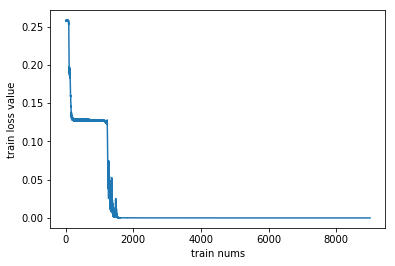

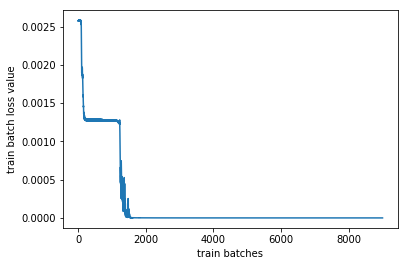

In [91]:
plt.plot(loss)

plt.ylabel('train loss value')
plt.xlabel('train nums')

plt.show()

plt.plot(batchloss)

plt.ylabel('train batch loss value')
plt.xlabel('train batches')

plt.show()

In [109]:
testloss = []
prediction = []
for i in range(0, 200,batch):
  l = 0
  x = test[0][i:i+batch, :]
  y = test[1][:,i:i+batch,:]
  testpred = pn(x)
  prediction.append(testpred)
  l+= tf.sqrt(tf.reduce_mean(tf.pow(testpred-y, 2.0)))
  lb = (l/batch)
  testloss.append(lb)
  
print(len(prediction))
  
"""  
  for k in range(batch):
    first = np.argmax(testpred[0,k,:])
    second = np.argmax(testpred[1,k,:])
    print("Predicted Indexes: (" + str(first) + "," + str(second)+") ")
    print(np.where(test[1][0,k,:])[0], np.where(test[1][1,k,:])[0])
  
"""


2


'  \n  for k in range(batch):\n    first = np.argmax(testpred[0,k,:])\n    second = np.argmax(testpred[1,k,:])\n    print("Predicted Indexes: (" + str(first) + "," + str(second)+") ")\n    print(np.where(test[1][0,k,:])[0], np.where(test[1][1,k,:])[0])\n  \n'